4: LES ARBRES DE DECISION: 
Nous allons tester maintenant les arbres de décisions. Dans ces arbres chaque noeud divise les observations en 2 branches en fonction d'une condition (par exemple alcohol<=12) et chaque feuille de l'arbre correspondra à une qualité égale à la moyenne de la qualité des observations présentes dans la feuille.
Une nouvelle observation x n'aura qu'à suivre le chemin de l'arbre en fonction des conditions des noeuds pour atterir dans une feuille. La prédiction sera alors la qualité de la feuille.

/home/henri/.local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(1074, 10)
(1074,)


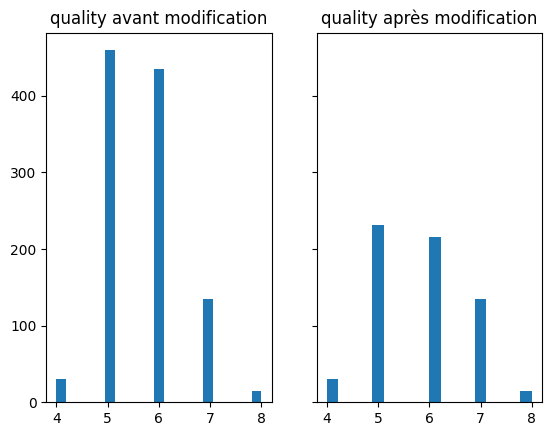

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
df = pd.read_csv('WineQT.csv')
import numpy as np
import matplotlib.pyplot as plt

def plot_hists(df):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
    for n in range(12):
        i = n % 3
        j = n % 4
        ax[i, j].hist(df.iloc[:, n], bins='auto')
        ax[i, j].set_xlabel(df.columns[n])

#On normalise : mettre entre 0 et 1
def normalize(df, property, parameter):
    df[property] = np.log(df[property] + parameter)


normalize(df, "fixed acidity", -2.3)
normalize(df, "sulphates", -0.24)
normalize(df, "total sulfur dioxide", 5)
normalize(df, "residual sugar", -1.1)
normalize(df, "chlorides", -0.005)
normalize(df, "volatile acidity", 2)
normalize(df, "free sulfur dioxide", 2)
#plot_hists(df)

standardized = (df - df.mean()) / df.std()
standardized = standardized[(np.abs(standardized) < 3).all(axis=1)]
rows = np.setdiff1d(list(df.index), list(standardized.index))
df.drop(index=rows, inplace=True)
#plot_hists(df)

import numpy as np
import matplotlib.pyplot as plt

#Préparation des données
y = df['quality']
X= [df['fixed acidity'],  df['volatile acidity']  ,df['citric acid']  ,df['residual sugar'],  df['chlorides'],df['free sulfur dioxide']  ,df['total sulfur dioxide'],  df['density']    ,df['pH'],  df['sulphates']]
X=np.transpose(np.array(X))
y=np.asarray(y)
print(X.shape)
print(y.shape)
X_features = ['fixed acidity',  'volatile acidity'  ,'citric acid'  ,'residual sugar',  'chlorides','free sulfur dioxide'  ,'total sulfur dioxide',  'density'    ,'pH',  'sulphates']
nb_feature=len(X_features)


#on supprime aleatoirement des valeurs de notes 5 et 6 (diviser par 2)
supp=[]
for i in range(len(y)):
    if y[i]==5 or y[i]==6:
        rand=random.random()
        if(rand>0.5):
            supp.append(i)
y2=np.delete(y,supp)

X2=np.delete(X,supp,0)

#Plot des modifications
fig,ax=plt.subplots(1,2,sharey=True)
ax[0].hist(y, bins='auto',label="quality")
ax[0].set_title("quality avant modification")

ax[1].hist(y2, bins='auto',label="quality")
ax[1].set_title("quality après modification")

#on créé les jeux de données
from sklearn.model_selection import train_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X2, y2, test_size=0.4, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

def zscore_normalize_features(X):
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)

 # normalize the original features
X_train, X_mu, X_sigma = zscore_normalize_features(X_train)
X_cv, X_mu, X_sigma = zscore_normalize_features(X_cv)
X_test, X_mu, X_sigma = zscore_normalize_features(X_test)

On va commencer par mettre en place un arbre de décision:

Pour cela :

- on commence à la racine avec tout le dataset qu'on veut split
- on teste les splits sur toutes les caractéristiques du vin avec un certain nombre de valeurs (ex: sulfate <= valeurn°12)
- on décide le split choisi en calculant l'utilité = le gain d'information qui dépend de la pureté des noeuds résultant du split
- on sépare le dataset en deux et on refait récursivement la même chose sur les 2 nouveaux noeuds.
- on s'arrête lorsque un noeud est totalement pure (=tous les vins de meme qualité), ou à une certaine profondeur

Code de l'arbre pour une multi-classification


In [19]:
#calcul de l'impureté d'un noeuf, pour savoir à quel point le noeud est pur (=les vins qui s'y trouvent ont la même qualité)
def gini_Impurity(y):
    """
    This function takes the splitted dataset, the indices we chose to split and returns the weighted entropy.
    """
    #on calcul le nombre de valeur par note de vin (0 à 8)
    tab_value=np.zeros(9)
    for loop in range(len(y)):
        tab_value[y[loop]]+=1
    #calcul de l'impureté
    impurity=1
    for loop in range(len(tab_value)):
        impurity-=(tab_value[loop]/sum(tab_value))**2
    return impurity
     
#split du noeud pour des valeurs continues (ex:split en fonction de la condition {X_alcohol<=12.355?})
def split_dataset_continue(X, node_indices, feature,t):

    left_indices = []
    right_indices = []
    for i in node_indices:
        if X[i,feature] <= t:
            left_indices.append(i)
        else:
            right_indices.append(i)
        
    return left_indices, right_indices 

#calcul du gain d'information = utilité d'un split, permet de choisir sur quelle condition on va split le noeud
def compute_information_gain_continue(X, y, node_indices, feature, t):
    
    left_indices, right_indices = split_dataset_continue(X, node_indices, feature,t)
    
    X_node, y_node = X[node_indices], y[node_indices]
    X_left, y_left = X[left_indices], y[left_indices]
    X_right, y_right = X[right_indices], y[right_indices]
    
    information_gain = 0
    
    node_entropy = gini_Impurity(y_node)
    left_entropy = gini_Impurity(y_left)
    right_entropy = gini_Impurity(y_right)
    w_left = len(X_left) / len(X_node)
    w_right = len(X_right) / len(X_node)
    weighted_entropy = w_left * left_entropy + w_right * right_entropy
    information_gain = node_entropy - weighted_entropy
    
    return information_gain

#garder la meilleur condition pour le meilleur split
def get_best_split_continue(X, y, node_indices):   
    num_features = X.shape[1]
    
    best_feature = -1

    max_info_gain = 0
    tmax=0

    tab_max_feature=np.zeros(num_features)
    tab_min_feature=np.zeros(num_features)
    for loop in range(num_features):
        tab_max_feature[loop]=np.max(np.transpose(X)[loop])
        tab_min_feature[loop]=np.min(np.transpose(X)[loop])
    
    for feature in range(num_features):
        tab_t_feature=np.linspace(tab_min_feature[feature], tab_max_feature[feature], len(X)-1)
        
        for t in range(len(tab_t_feature)):
            info_gain = compute_information_gain_continue(X, y, node_indices, feature,tab_t_feature[t])

            if info_gain > max_info_gain:
                max_info_gain = info_gain
                best_feature = feature
                tmax=tab_t_feature[t]
   
    return best_feature,tmax,max_info_gain

#construction recursive de l'arbre de décision:
#on commence à la racine avec tout le dataset
#on teste les splits sur toutes les caractéristiques du vin avec un certain nombre de valeurs (ex: sulfate <= valeurn°12)
#on décide la condition choisie en calculant l'utilité = le gain d'information qui dépend de la pureté des noeuds résultant du split
#on sépare le dataset en deux et on refait récursivement la même chose sur les 2 nouveaux noeuds.
#on s'arrête lorsque un noeud est totalement pure (=tous les vins de meme qualité), ou à une certaine profondeur
def build_tree_recursive_continue(X, y, node_indices, branch_name, max_depth, current_depth, tree):

    if current_depth == max_depth:
        formatting = " "*current_depth + "-"*current_depth
        print(formatting, "%s leaf node with indices" % branch_name, node_indices)
        print(formatting,"note moyenne attribuée à la feuille :",np.mean(y[node_indices]),"(",round(np.mean(y[node_indices])),")")
        return 0
   

    best_feature,tmax,max_info = get_best_split_continue(X, y, node_indices) 
    
    formatting = "-"*current_depth
    print("%s Depth %d, %s: Split on feature: %s <= %s, pour un gain de %s" % (formatting, current_depth, branch_name, X_features[best_feature], tmax,max_info))

    left_indices, right_indices = split_dataset_continue(X, node_indices, best_feature,tmax)
    tree.append((left_indices, right_indices, best_feature,tmax))
    
    build_tree_recursive_continue(X, y, left_indices, "Left", max_depth, current_depth+1, tree)
    build_tree_recursive_continue(X, y, right_indices, "Right", max_depth, current_depth+1, tree)
    return tree

Test de l'arbre de décision: On ne va qu'à une profondeur de 2...

In [23]:
tree = []
root_indices=list(range(0, len(X_train)))
build_tree_recursive_continue(X_train, y_train,root_indices, "Root", max_depth=3, current_depth=0, tree = tree);

/tmp/ipykernel_42683/3297919408.py:13: RuntimeWarning: invalid value encountered in double_scalars
  impurity-=(tab_value[loop]/sum(tab_value))**2


 Depth 0, Root: Split on feature: sulphates <= -0.4387070165807345, pour un gain de 0.05362897506253106
- Depth 1, Left: Split on feature: density <= 0.12832861014549923, pour un gain de 0.06507649925300424
-- Depth 2, Left: Split on feature: sulphates <= -1.0524893322866307, pour un gain de 0.03761937716262964
   --- Left leaf node with indices [6, 17, 23, 26, 29, 38, 42, 66, 68, 78, 92, 99, 111, 120, 128, 176, 179, 192, 213, 224, 232, 247, 268, 277, 279, 280, 287, 295, 320, 331, 346, 347, 351, 366, 372]
   --- note moyenne attribuée à la feuille : 5.2 ( 5 )
   --- Right leaf node with indices [2, 3, 8, 30, 31, 33, 41, 45, 51, 57, 59, 73, 75, 79, 95, 109, 117, 124, 125, 126, 142, 146, 154, 167, 172, 186, 191, 194, 201, 210, 215, 217, 219, 223, 225, 226, 231, 234, 238, 246, 272, 291, 293, 299, 313, 328, 338, 343, 348, 370]
   --- note moyenne attribuée à la feuille : 5.5 ( 6 )
-- Depth 2, Right: Split on feature: residual sugar <= 0.4592063818332184, pour un gain de 0.02071005917159776

In [ ]:
Il faudrait faire passer toutes les observations du jeu de test dans l arbre pour obtenir leurs notes prédites. 
Mais nous allons directement mettre en place la random forest à l aide la bibliothèque sklearn et xgboost.
Random forest va créer plein d arbres de décision avec une part d aléatoire dans le choix des splits et choisir l arbre final graĉe à un système de votes.

RANDOM FOREST POUR LA QUALITE DU VIN

In [25]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')

RANDOM_STATE = 55 ## We will pass it to every sklearn call so we ensure reproducibility

In [27]:
X_train=X_norm2
y_train=y_train2
n = int(len(X_train)*0.8) ## Let's use 80% to train and 20% to eval
print(int(len(y_train)*0.8)) ## Let's use 80% to train and 20% to eval

from sklearn.preprocessing import LabelEncoder
print(y_train)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
print(y_train)

914
[5 5 5 ... 5 6 5]
[2 2 2 ... 2 3 2]


In [28]:
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,verbosity = 1, random_state = RANDOM_STATE)
xgb_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)], early_stopping_rounds = 10)

/home/henri/.local/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBoostError: [18:11:37] ../src/metric/multiclass_metric.cu:34: Check failed: label_error >= 0 && label_error < static_cast<int32_t>(n_class): MultiClassEvaluation: label must be in [0, num_class), num_class=6 but found 7 in label
Stack trace:
  [bt] (0) /home/henri/.local/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x328fa3) [0x7f7b6f0c4fa3]
  [bt] (1) /home/henri/.local/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x5f8494) [0x7f7b6f394494]
  [bt] (2) /home/henri/.local/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x2dd924) [0x7f7b6f079924]
  [bt] (3) /home/henri/.local/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(XGBoosterEvalOneIter+0x322) [0x7f7b6eedd3c2]
  [bt] (4) /lib/x86_64-linux-gnu/libffi.so.7(+0x6ff5) [0x7f7bcc6d1ff5]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.7(+0x640a) [0x7f7bcc6d140a]
  [bt] (6) /usr/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(_ctypes_callproc+0x5b6) [0x7f7bcc164306]
  [bt] (7) /usr/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(+0x139dc) [0x7f7bcc1649dc]
  [bt] (8) /bin/python3(_PyObject_MakeTpCall+0x296) [0x5f7056]



In [21]:
xgb_model.best_iteration

20

In [22]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}")

print(xgb_model.classes_)
#print(xgb_model.classes_)

Metrics train:
	Accuracy score: 0.8537
Metrics test:
	Accuracy score: 0.8537
[0 1 2 3 4 5]
